In [1]:
%%bash
# output the project's file structure
tree ..

..
├── LICENSE
├── Makefile
├── README.md
├── artifacts
│   ├── data
│   │   ├── processed
│   │   │   ├── X_test.parquet
│   │   │   ├── X_train.parquet
│   │   │   ├── y_test.parquet
│   │   │   └── y_train.parquet
│   │   └── raw
│   │       └── bodyfat.sqlite
│   ├── features
│   │   ├── test.parquet
│   │   └── train.parquet
│   └── models
│       └── model.json.dvc
├── bin
│   ├── build-dataset
│   ├── build-features
│   └── train-model
├── dvc.lock
├── dvc.yaml
├── experiments
│   ├── metrics.json
│   └── plots
│       └── metrics
│           ├── r2_train.tsv
│           └── r2_val.tsv
├── notebooks
│   └── bodyfat-prediction-service.ipynb
├── params.yaml
├── poetry.lock
├── pyproject.toml
├── src
│   ├── __init__.py
│   ├── app.py
│   ├── config.py
│   ├── data
│   │   ├── __init__.py
│   │   ├── dataset.py
│   │   └── dataset_builder.py
│   ├── features
│   │   ├── __init__.py
│   │   └── feature_builder.py
│   └── models
│       ├── __init__.py
│       └── trainer.py
└── test

#### **`Dependencies`**

In [2]:
import random
import sqlite3
import warnings

from pathlib import PosixPath

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pydantic import BaseModel, NonNegativeFloat
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor

from src.config import Config, load_config, seed_everything

warnings.filterwarnings("ignore")
seed_everything()

In [3]:
# matplotlib config
COLORS: list[str] = ["#bae1ff", "#ffb3ba"]

MPL_STYLE: dict[str, str | float | bool] = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "axes.titlesize": "medium",
    "axes.labelsize": "medium",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}
mpl.rcParams.update(MPL_STYLE)
sns.color_palette(COLORS)

[(0.7294117647058823, 0.8823529411764706, 1.0),
 (1.0, 0.7019607843137254, 0.7294117647058823)]

#### **`Basic EDA`**

In [4]:
# (1) query all the data from the 'bodyfat.sqlite' database's 'bodyfat' table, and ...
# (2) read in as a pd.DataFrame
DB_PATH: PosixPath = Config.Path.DATA_DIR / "raw" / "bodyfat.sqlite"
df: pd.DataFrame = (
    pd.read_sql_query("SELECT * FROM bodyfat", sqlite3.connect(DB_PATH))
    .drop("Original", axis=1)
)

# re-assign the column names
df.columns = load_config().data.column_names

# create three new features, that is, ...
# (1) 'bmi' or body mass index, ...
# (2) 'bai' or body adiposity index, and ...
# (3) 'whr' or waist to hip ratio
df = (
    df
    .assign(
        bmi=df["weight"] / (df["height"] ** 2), 
        bai=(df["hip"] / (df["height"] ** 1.5)) - 18, 
        whr=df["abdomen"] / df["hip"]
    )
)

# output the 'df' pd.DataFrame
df

,body_fat,sex,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist,bmi,bai,whr
0,12.30,M,23,69.9700,1.7200,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.651298,23.892776,0.901587
1,6.10,M,22,78.5900,1.8400,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.213020,21.544894,0.840932
2,25.30,M,22,69.8500,1.6800,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.748441,27.556227,0.886089
3,10.40,M,26,83.8000,1.8400,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.751890,22.546538,0.853755
4,28.70,M,24,83.5800,1.8100,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.512042,23.846228,0.981354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,30.40,F,23,59.8752,1.5621,31.3,89.0,71.0,98.5,56.0,36.2,21.0,28.0,24.5,16.3,24.537443,32.451372,0.720812
432,7.47,F,21,48.5352,1.5748,29.5,79.0,62.5,89.0,49.0,33.0,20.0,25.0,22.0,15.5,19.570684,27.035179,0.702247
433,11.98,F,20,51.7104,1.5748,31.5,81.5,61.5,90.0,49.5,32.0,19.5,27.5,22.5,15.0,20.851009,27.541193,0.683333
434,11.24,F,22,50.8032,1.6510,30.5,85.0,64.0,88.0,45.0,32.0,19.5,24.0,21.5,15.0,18.637898,23.482227,0.727273


In [5]:
# extract the 'most informative' features based on the mutual information criterion
# NOTE: the 'most informative' features are stored in ../params.yaml under features/mutual_info
scores: np.ndarray = mutual_info_regression(
    df.assign(sex=pd.factorize(df["sex"])[0]).drop("body_fat", axis=1), 
    df["body_fat"], 
    discrete_features=df.assign(sex=pd.factorize(df["sex"])[0]).drop("body_fat", axis=1).dtypes==int
)
informative_features: list[str] = [
    col for col, score in zip(df.drop("body_fat", axis=1).columns, scores) 
    if score > scores.mean()
]

# filter the 'df' pd.DataFrame w.r.t. the 'most informative' features
df = df[["sex"] + informative_features + ["body_fat"]].copy(deep=True)

# output the updated 'df' pd.DataFrame
df

,sex,weight,chest,abdomen,hip,biceps,bmi,bai,whr,body_fat
0,M,69.9700,93.1,85.2,94.5,32.0,23.651298,23.892776,0.901587,12.30
1,M,78.5900,93.6,83.0,98.7,30.5,23.213020,21.544894,0.840932,6.10
2,M,69.8500,95.8,87.9,99.2,28.8,24.748441,27.556227,0.886089,25.30
3,M,83.8000,101.8,86.4,101.2,32.4,24.751890,22.546538,0.853755,10.40
4,M,83.5800,97.3,100.0,101.9,32.2,25.512042,23.846228,0.981354,28.70
...,...,...,...,...,...,...,...,...,...,...
431,F,59.8752,89.0,71.0,98.5,28.0,24.537443,32.451372,0.720812,30.40
432,F,48.5352,79.0,62.5,89.0,25.0,19.570684,27.035179,0.702247,7.47
433,F,51.7104,81.5,61.5,90.0,27.5,20.851009,27.541193,0.683333,11.98
434,F,50.8032,85.0,64.0,88.0,24.0,18.637898,23.482227,0.727273,11.24


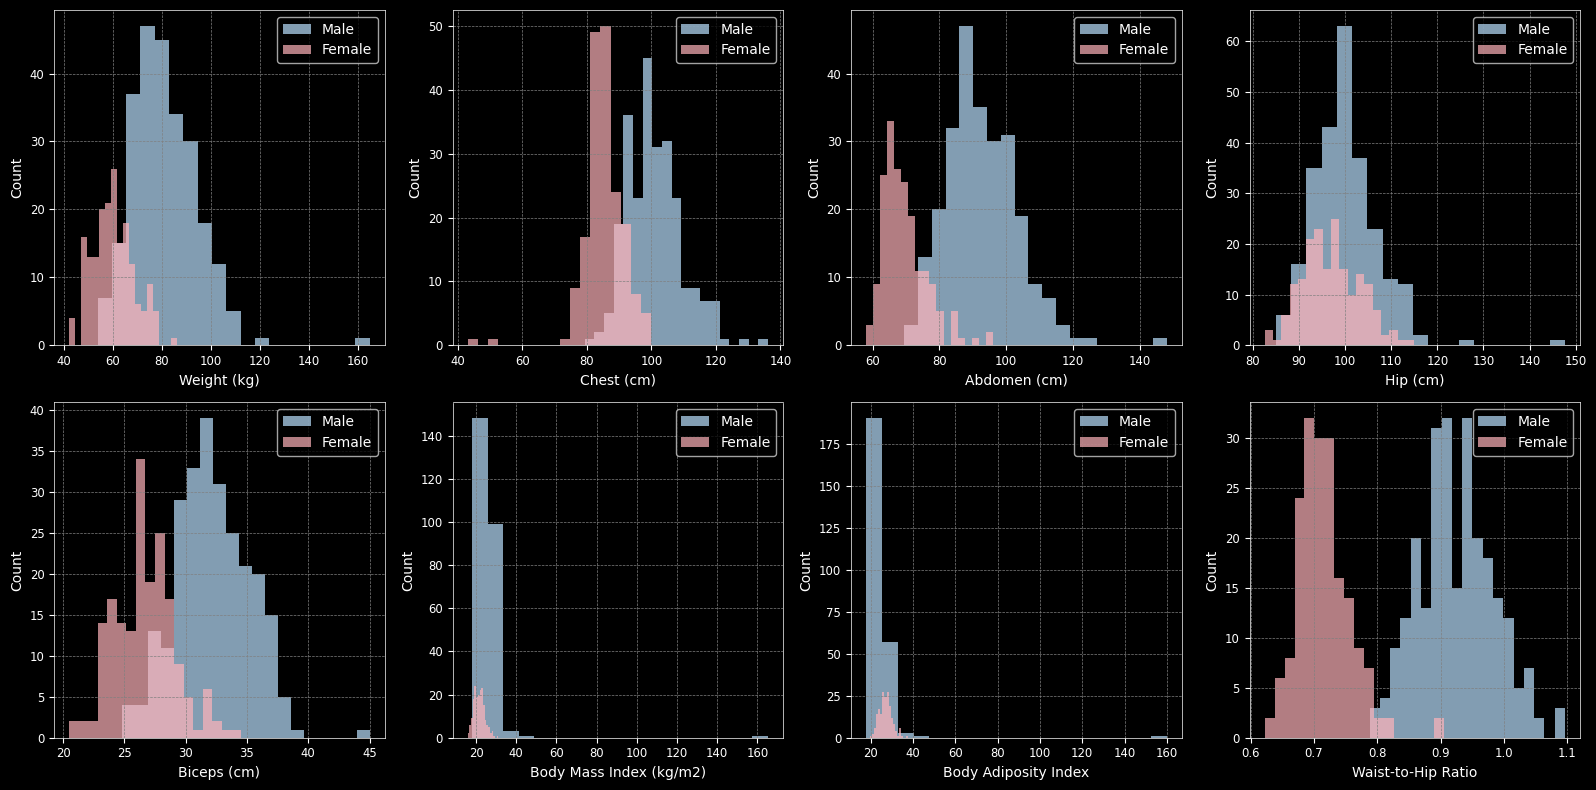

In [6]:
# plot the distribution of each informative feature w.r.t. gender
col_mapper: dict[str, str] = {
    "weight": "Weight (kg)", 
    "chest": "Chest (cm)", 
    "abdomen": "Abdomen (cm)", 
    "hip": "Hip (cm)", 
    "biceps": "Biceps (cm)",
    "bmi": "Body Mass Index (kg/m2)", 
    "bai": "Body Adiposity Index", 
    "whr": "Waist-to-Hip Ratio",
}

i: int = 1
plt.figure(figsize=(16, 8))
for col, description in col_mapper.items():
    plt.subplot(2, 4, i)
    n_bins: int = int(np.round(1 + (3.322 * np.log(df.query("sex == 'M'").shape[0]))))
    plt.hist(df.query("sex == 'M'")[col], bins=n_bins, color=COLORS[0], alpha=0.7, label="Male")
    n_bins = int(np.round(1 + (3.322 * np.log(df.query("sex == 'F'").shape[0]))))
    plt.hist(df.query("sex == 'F'")[col], bins=n_bins, color=COLORS[1], alpha=0.7, label="Female")
    plt.xlabel(description)
    plt.ylabel("Count")
    plt.legend(loc="best", frameon=True)
    i += 1
plt.tight_layout();

#### **`Inference`**

In [7]:
%%bash 
# list the items stored in ../artifacts/models
cd ../artifacts/models 
tree

.
└── model.json.dvc

1 directory, 1 file


In [8]:
%%bash
# NOTE: execute this cell if ../artifacts/models/model.json doesn't exist
# download the trained model artifact, 'model.json', from the remote dvc repo to ../artifacts/models
cd ..
dvc pull artifacts/models/model.json.dvc

A       artifacts/models/model.json
1 file added


In [9]:
%%bash
# confirm that 'model.json' has been downloaded locally to ../artifacts/models
cd ../artifacts/models 
tree

.
├── model.json
└── model.json.dvc

1 directory, 2 files


In [10]:
# load the trained model
model: XGBRegressor = XGBRegressor()
model.load_model(Config.Path.MODELS_DIR / "model.json")

In [11]:
# load the test set features and labels
x_test: pd.DataFrame = pd.read_parquet(Config.Path.FEATURES_DIR / "test.parquet")
y_test: pd.Series = pd.read_parquet(Config.Path.DATA_DIR / "processed" / "y_test.parquet").squeeze()

In [12]:
# extract a random record from the test set features
idx: int = random.choice(x_test.index)
record: pd.DataFrame = x_test.loc[idx, :].to_frame().T

# output the label and prediction
prediction: float = model.predict(record)[0]
print(f"Actual bodyfat %: {y_test.loc[idx]:.2f}\nPredicted bodyfat %: {prediction:.2f}")

Actual bodyfat %: 19.60
Predicted bodyfat %: 19.82


In [13]:
# a list of features that the model was trained on
model.feature_names_in_.tolist()

['weight', 'chest', 'abdomen', 'hip', 'biceps', 'bmi', 'bai', 'whr']

In [14]:
class Record(BaseModel):
    weight: NonNegativeFloat
    chest: NonNegativeFloat
    abdomen: NonNegativeFloat
    hip: NonNegativeFloat
    biceps: NonNegativeFloat
    bmi: NonNegativeFloat
    bai: NonNegativeFloat
    whr: NonNegativeFloat

In [15]:
# (1) instantiate an object of type, 'Record'
# (2) convert the 'Record' object to a dict[str, float] via the 'model_dump' method 
# (3) convert the dict[str, float] to a pd.DataFrame
# (4) return the pd.DataFrame with both the input features and predicted label
record: Record = Record(
    weight=random.choice(x_test["weight"].tolist()), 
    chest=random.choice(x_test["chest"].tolist()), 
    abdomen=random.choice(x_test["abdomen"].tolist()), 
    hip=random.choice(x_test["hip"].tolist()), 
    biceps=random.choice(x_test["biceps"].tolist()), 
    bmi=random.choice(x_test["bmi"].tolist()), 
    bai=random.choice(x_test["bai"].tolist()), 
    whr=random.choice(x_test["whr"].tolist())
)
record: dict[str, float] = record.model_dump()
record: pd.DataFrame = pd.DataFrame([record])
record.assign(predicted_bodyfat=model.predict(record)[0])

,weight,chest,abdomen,hip,biceps,bmi,bai,whr,predicted_bodyfat
0,61.6896,103.9,95.0,100.1,32.5,23.21302,23.90303,0.856044,17.104301
